# 🧠 Artificial Neural Networks and Deep Learning

---

## Homework 2: Dataset Inspection & Creation

## 🌐 Connect Colab to Google Drive

Google Drive connection for the owner of the Drive folder

In [41]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/DeepL/DeepL Team/Homework 2/Matteo

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/DeepL/DeepL Team/Homework 2/Matteo


Google Drive connection for other team members

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/DeepL Team/Homework 2/Lorenzo

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1XqCxOkXIFV81NU8IlltS38bM65k9N-bR/DeepL Team/Homework 2/Lorenzo


## ⚙️ Import Libraries

In [42]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
np.random.seed(42)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2.17.1
TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 0


## ⏳ Load the Data

In [43]:
data = np.load("../Dataset/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


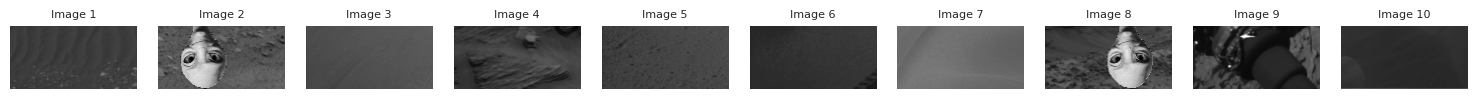

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(15, 3))  # 1 row, 10 columns
for i, ax in enumerate(axes):
    ax.imshow(X_train[2300+i], cmap='gray', vmin=0, vmax=255)  # Display each image
    ax.axis('off')  # Turn off axis for each subplot
    ax.set_title(f"Image {i+1}", fontsize=8)  # Optional: title for each image

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

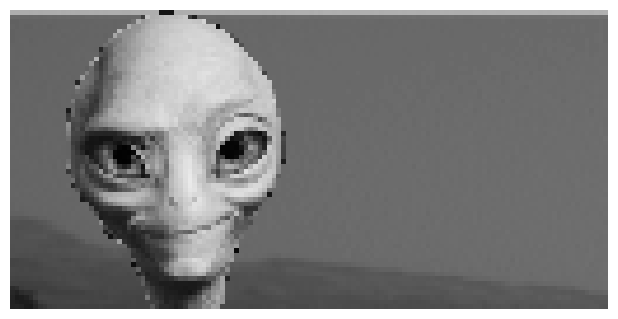

In [ ]:
plt.imshow(X_train[2614], cmap='gray', vmin=0, vmax=255)  # Display each image
plt.axis('off')  # Turn off axis for each subplot
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

### 👽 Alien detection

In [44]:
np.array_equal(y_train[2000],y_train[2002])

True

In [45]:
lis_aliens=[]
for i in range(len(y_train)):
  if np.array_equal(y_train[i],y_train[2000]):
    lis_aliens.append(i)
len(lis_aliens)

110

In [46]:
X_train=np.delete(X_train,lis_aliens,axis=0)
y_train=np.delete(y_train,lis_aliens,axis=0)

In [47]:
X_train.shape

(2505, 64, 128)

### 📤 Other potential outliers

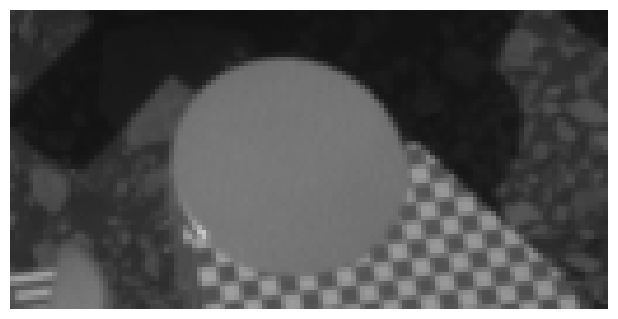

In [ ]:
plt.imshow(X_train[1371], cmap='gray', vmin=0, vmax=255)  # Display each image
plt.axis('off')  # Turn off axis for each subplot
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

## 🎓 Dataset without outliers

In [48]:
#Final dataset
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(type(X_train[0][0][0]))
print(type(X_test[0][0][0]))

(2505, 64, 128)
(2505, 64, 128)
(10022, 64, 128)
<class 'numpy.float64'>
<class 'numpy.uint8'>


In [ ]:
# Create directories for images and labels
os.makedirs('../Dataset/data', exist_ok=True)
os.makedirs('../Dataset/labels', exist_ok=True)

# Save images and corresponding labels (assuming images and labels are 4D arrays)
# Example shapes: images (num_images, height, width, channels), labels (num_images, height, width, 1)
for i, (img) in enumerate(X_train):
    # Save image
    img_path = os.path.join('../Dataset/data', f'image_{i:05d}.png')  # Zero-padded filenames for consistency
    img=img.astype(np.uint8)
    Image.fromarray(img).save(img_path)

for i, (lbl) in enumerate(y_train):
    # Save label
    lbl_path = os.path.join('../Dataset/labels', f'label_{i:05d}.png')
    lbl=lbl.astype(np.uint8)
    Image.fromarray(lbl).save(lbl_path)

## 🔊 Augmented dataset

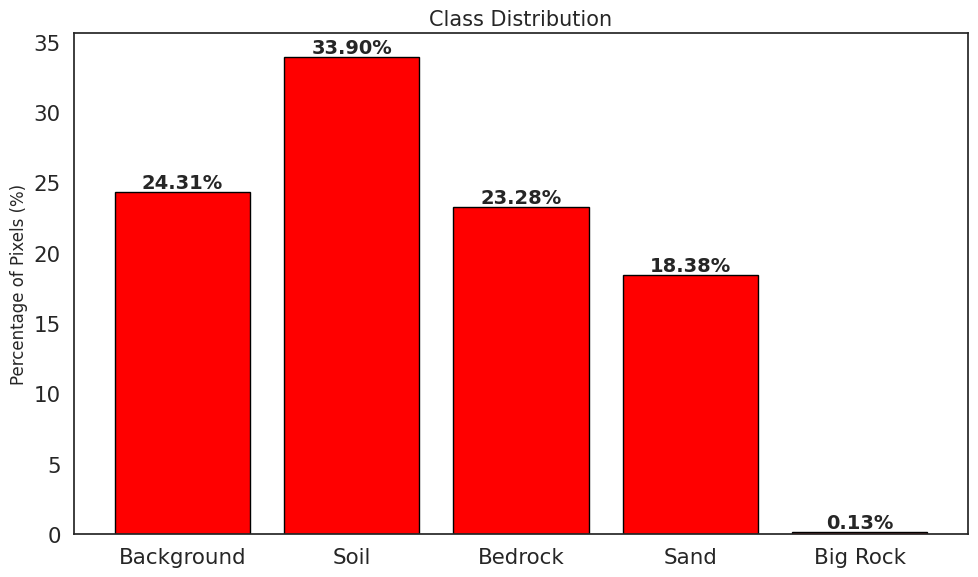

In [50]:
def plot_class_distribution(Y_train):
    """
    Plot class distribution for semantic segmentation labels.

    Parameters:
    Y_train (numpy.ndarray): Label array with shape (num_images, height, width)
    """

    # Detailed explanation of class meanings
    class_meanings = {
        0: "Background",
        1: "Soil",
        2: "Bedrock",
        3: "Sand",
        4: "Big Rock"
    }

    # Flatten the labels to count pixel occurrences
    flat_labels = Y_train.flatten()

    # Count occurrences of each class
    unique, counts = np.unique(flat_labels, return_counts=True)

    # Calculate percentage
    total_pixels = len(flat_labels)
    percentages = (counts / total_pixels) * 100

    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(unique, percentages, color='red', edgecolor='black')
    plt.title('Class Distribution', fontsize=15)
    plt.ylabel('Percentage of Pixels (%)', fontsize=12)
    plt.xticks(unique, [class_meanings.get(i, f'Class {i}') for i in unique])

    # Add percentage labels on top of each bar
    for i, percentage in enumerate(percentages):
        plt.text(unique[i], percentage, f'{percentage:.2f}%',
                 ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_class_distribution(y_train)

Solve class imbalance:

In [56]:
import numpy as np
import random

def balance_dataset(X_train, Y_train, target_class=4, balance_strategy='duplicate'):
    """
    Balance the dataset by augmenting images containing a specific target class.

    Parameters:
    X_train (numpy.ndarray): Input images array with shape (num_images, height, width, channels)
    Y_train (numpy.ndarray): Label array with shape (num_images, height, width)
    target_class (int): The class to balance (default is 4 for big rock)
    balance_strategy (str): Strategy for balancing - 'duplicate' or 'augment'

    Returns:
    tuple: Balanced (X_train, Y_train) arrays
    """
    # Find images containing the target class
    target_class_images = np.where(np.any(Y_train == target_class, axis=(1,2)))[0]

    # Find images not containing the target class
    non_target_class_images = np.where(~np.any(Y_train == target_class, axis=(1,2)))[0]

    # Calculate how many images we need to add
    num_non_target = len(non_target_class_images)
    num_target = len(target_class_images)

    if num_target >= num_non_target:
        print("Dataset is already balanced for the target class.")
        return X_train, Y_train

    # Determine how many images to add
    images_to_add = 5000

    # Select images to duplicate
    if balance_strategy == 'duplicate':
        # Simple duplication
        indices_to_duplicate = np.random.choice(target_class_images, size=images_to_add, replace=True)

        # Create new arrays to add
        X_to_add = X_train[indices_to_duplicate]
        Y_to_add = Y_train[indices_to_duplicate]

    elif balance_strategy == 'augment':
        # More advanced augmentation (basic example)
        indices_to_augment = np.random.choice(target_class_images, size=images_to_add, replace=True)

        # Create arrays to store augmented images
        X_to_add = np.empty_like(X_train[indices_to_augment])
        Y_to_add = np.empty_like(Y_train[indices_to_augment])

        for i, (img, mask) in enumerate(zip(X_train[indices_to_augment], Y_train[indices_to_augment])):
            # Simple augmentations
            augment_type = random.choice(['flip', 'rotate', 'brightness'])

            if augment_type == 'flip':
                # Horizontal flip
                X_to_add[i] = np.fliplr(img)
                Y_to_add[i] = np.fliplr(mask)
            elif augment_type == 'rotate':
                # 90-degree rotation
                X_to_add[i] = np.rot90(img)
                Y_to_add[i] = np.rot90(mask)
            else:
                # Brightness adjustment
                brightness_factor = np.random.uniform(0.8, 1.2)
                X_to_add[i] = np.clip(img * brightness_factor, 0, 255).astype(img.dtype)
                Y_to_add[i] = mask

    else:
        raise ValueError("Invalid balance strategy. Choose 'duplicate' or 'augment'.")

    # Concatenate original and new images
    X_balanced = np.concatenate([X_train, X_to_add], axis=0)
    Y_balanced = np.concatenate([Y_train, Y_to_add], axis=0)

    print(f"Original dataset size: {len(X_train)}")
    print(f"Balanced dataset size: {len(X_balanced)}")

    print(f"Original dataset size: {len(Y_train)}")
    print(f"Balanced dataset size: {len(Y_balanced)}")

    # Optional: Shuffle the balanced dataset
    indices = np.random.permutation(len(X_balanced))
    X_balanced = X_balanced[indices]
    Y_balanced = Y_balanced[indices]

    return X_balanced, Y_balanced

In [57]:
X_balanced, Y_balanced = balance_dataset(X_train, y_train, target_class=4, balance_strategy='duplicate')

Original dataset size: 2505
Balanced dataset size: 7505
Original dataset size: 2505
Balanced dataset size: 7505


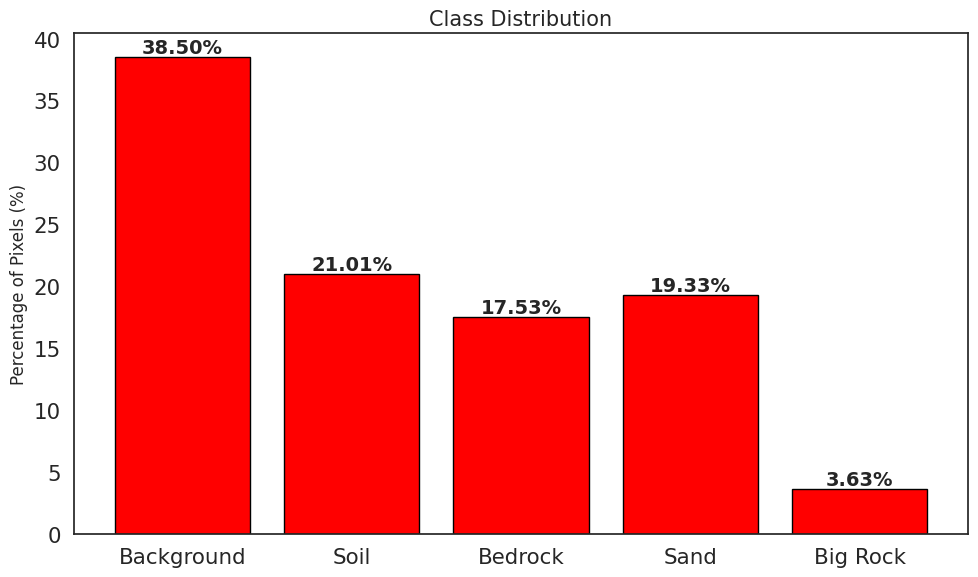

In [53]:
plot_class_distribution(Y_balanced)

In [54]:
# Create directories for images and labels
os.makedirs('../Dataset/data_aug', exist_ok=True)
os.makedirs('../Dataset/labels_aug', exist_ok=True)

# Save images and corresponding labels (assuming images and labels are 4D arrays)
# Example shapes: images (num_images, height, width, channels), labels (num_images, height, width, 1)
for i, (img) in enumerate(X_balanced):
    # Save image
    img_path = os.path.join('../Dataset/data_aug', f'image_{i:05d}.png')  # Zero-padded filenames for consistency
    img=img.astype(np.uint8)
    Image.fromarray(img).save(img_path)

for i, (lbl) in enumerate(Y_balanced):
    # Save label
    lbl_path = os.path.join('../Dataset/labels_aug', f'label_{i:05d}.png')
    lbl=lbl.astype(np.uint8)
    Image.fromarray(lbl).save(lbl_path)

In [55]:
X_balanced.shape

(7505, 64, 128)

In [58]:
Y_balanced.shape

(7505, 64, 128)